In [1]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00


# Emotion Detection - KDEF

Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-using-transfer)

## Library Preparation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

## Import Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download stevemarcelloliem/kdef-raf-fer-complete

Dataset URL: https://www.kaggle.com/datasets/stevemarcelloliem/kdef-raf-fer-complete
License(s): MIT
 98% 633M/649M [00:01<00:00, 286MB/s]
100% 649M/649M [00:01<00:00, 387MB/s]


In [8]:
!unzip kdef-raf-fer-complete.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Val/happy/Training_88720851.jpg_processed.jpg  
  inflating: Val/happy/Training_88776166.jpg_processed.jpg  
  inflating: Val/happy/Training_88800063.jpg_processed.jpg  
  inflating: Val/happy/Training_88873273.jpg_processed.jpg  
  inflating: Val/happy/Training_88917842.jpg_processed.jpg  
  inflating: Val/happy/Training_88964675.jpg_processed.jpg  
  inflating: Val/happy/Training_89046745.jpg_processed.jpg  
  inflating: Val/happy/Training_89107622.jpg_processed.jpg  
  inflating: Val/happy/Training_89184566.jpg_processed.jpg  
  inflating: Val/happy/Training_8939285.jpg_processed.jpg  
  inflating: Val/happy/Training_89460378.jpg_processed.jpg  
  inflating: Val/happy/Training_89632094.jpg_processed.jpg  
  inflating: Val/happy/Training_89635895.jpg_processed.jpg  
  inflating: Val/happy/Training_89641436.jpg_processed.jpg  
  inflating: Val/happy/Training_89752835.jpg_processed.jpg  
  inflating: Val/happy/Trai

## Data Engineering

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/' # Set data_dir explicitly to /content
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x.lower()]) # Use x.lower() to get 'train' or 'val' for data_transforms
                  for x in ['Train', 'Val']} # Use 'Train' and 'Val' to match directory names
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['Train', 'Val']} # Use 'Train' and 'Val'
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val']} # Use 'Train' and 'Val'
class_names = image_datasets['Train'].classes # Use 'Train'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


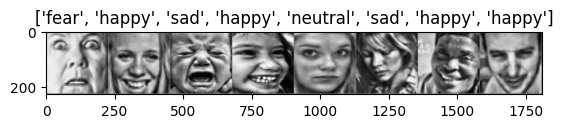

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Development

Now, let's write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch optim.lr_scheduler.

In [15]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']: # Changed to 'Train' and 'Val'
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc: # Changed to 'Val'
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/densenet.pt')

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning /w Covnet

Load a pretrained model and reset final fully connected layer.

In [17]:
model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/densenet161_full')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model Train and Evaluate

In [19]:
import os
if not os.path.exists('saved'):
    os.makedirs('saved')

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=20)

Epoch 0/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:03<00:00,  4.86it/s]


Train Loss: 0.8925 Acc: 0.6808


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:11<00:00, 14.80it/s]


Val Loss: 0.8625 Acc: 0.6919

Epoch 1/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:03<00:00,  4.86it/s]


Train Loss: 0.7652 Acc: 0.7256


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:11<00:00, 14.82it/s]


Val Loss: 0.8698 Acc: 0.7031

Epoch 2/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:04<00:00,  4.86it/s]


Train Loss: 0.6665 Acc: 0.7650


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:11<00:00, 14.74it/s]


Val Loss: 0.8476 Acc: 0.7089

Epoch 3/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:06<00:00,  4.85it/s]


Train Loss: 0.5754 Acc: 0.7964


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:12<00:00, 14.72it/s]


Val Loss: 0.8677 Acc: 0.7103

Epoch 4/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:04<00:00,  4.86it/s]


Train Loss: 0.3650 Acc: 0.8759


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:12<00:00, 14.71it/s]


Val Loss: 0.7982 Acc: 0.7430

Epoch 5/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:05<00:00,  4.85it/s]


Train Loss: 0.2859 Acc: 0.9052


100%|██████████| 1061/1061 [01:12<00:00, 14.62it/s]


Val Loss: 0.8685 Acc: 0.7376

Epoch 6/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:04<00:00,  4.85it/s]


Train Loss: 0.2476 Acc: 0.9216


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:12<00:00, 14.71it/s]


Val Loss: 0.8419 Acc: 0.7441

Epoch 7/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:04<00:00,  4.85it/s]


Train Loss: 0.2129 Acc: 0.9357


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:12<00:00, 14.69it/s]


Val Loss: 0.8774 Acc: 0.7390

Epoch 8/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:04<00:00,  4.86it/s]


Train Loss: 0.1774 Acc: 0.9465


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:12<00:00, 14.70it/s]


Val Loss: 0.9106 Acc: 0.7377

Epoch 9/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 4392/4392 [15:04<00:00,  4.86it/s]


Train Loss: 0.1602 Acc: 0.9520


  0%|          | 0/1061 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1061/1061 [01:12<00:00, 14.66it/s]


Val Loss: 0.9315 Acc: 0.7362

Epoch 10/19
----------


  0%|          | 0/4392 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 54%|█████▍    | 2369/4392 [08:07<06:49,  4.94it/s]

## Model Evaluation

In [ ]:
model_ft.load_state_dict(torch.load('saved/densenet.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['Train', 'Val']}

In [ ]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['Val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)

        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)